# Volume 4: Linear Quadratic Gaussian Control
    Daniel Perkins
    MATH 439
    2/5/25

In [129]:
import numpy as np
from jax import numpy as jnp
from scipy.linalg import inv
from matplotlib import pyplot as plt

from utils import Simulator, Estimator, Controller
from animate import animate2d, animate3d

# Problem 1

In [109]:
class LQR:
    """
    Given a transition system and cost matrices, compute an optimal trajectory,
    an associated control, and an optimal control rule given state feedback.
    """

    def __init__(self, Q, M, R, A, B, N):
        # Store the attributes
        self.Q = Q
        self.M = M
        self.R = R
        self.A = A
        self.B = B
        self.N = N

    def fit(self):
        """
        Computes and saves the gain matrices Ks
        """
        # Initialize empty arrays for K and P
        Ks = [None] * self.N
        Ps = np.empty((self.N+1, self.M.shape[0], self.M.shape[1]))
        Ps[self.N] = self.M  # 24.5
        
        for k in range(self.N, 0, -1):  # Equations 24.3 and 24.4
            Ks[k-1] = -inv(self.R + self.B.T @ Ps[k] @ self.B) @ self.B.T @ Ps[k] @ self.A
            Ps[k-1] = self.Q + self.A.T @ Ps[k] @ self.A - self.A.T @ Ps[k] @ self.B @ (-Ks[k-1])
            
        self.Ks = Ks

    def compute_control(self, k, x_k):
        """
        Returns the optimal control uk

        Parameters:
            k (int) - The index of the state vector
            x_k (ndarray) - The state at index k

        Returns:
            u_k (ndarray) - The optimal control at index k
        """
        return self.Ks[k] @ x_k

# Problem 2

In [110]:
delta_t = 1/10.

# x_k = Ax_{k-1} + Bu_{k-1}
# Create first evolution matrix A
A = np.eye(6)
A[0, 3], A[1, 4], A[2, 5] = delta_t, delta_t, delta_t

# Create second evolution matrix B
B = np.zeros((6, 3))
B[3, 0], B[4, 1], B[5, 2] = delta_t, delta_t, delta_t


# Problem 3

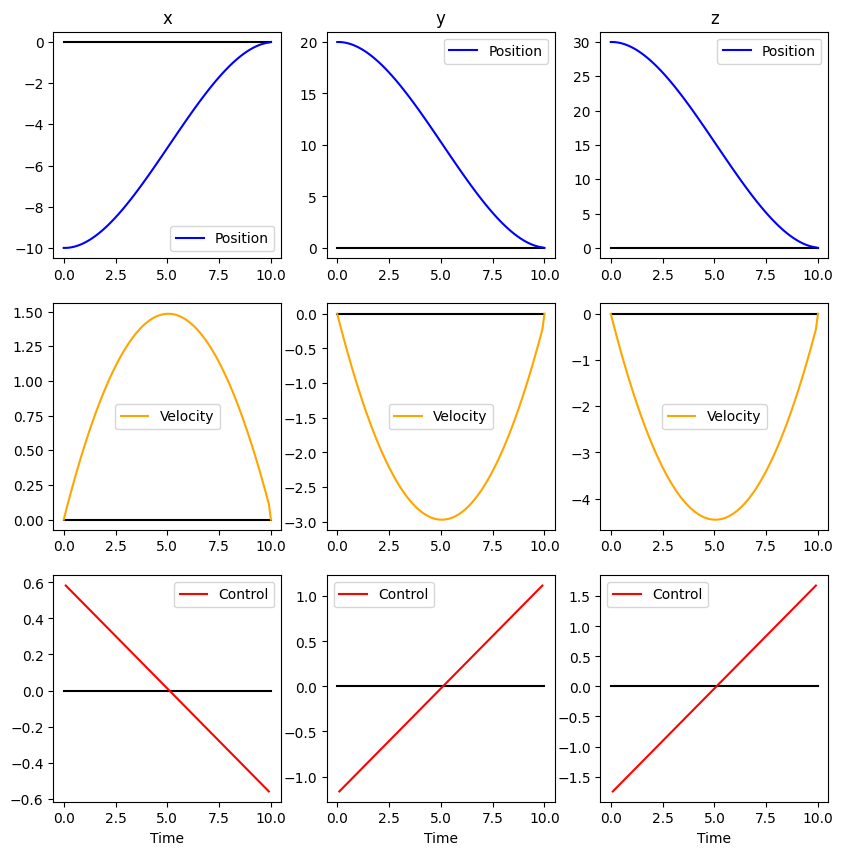

In [111]:
# Initialize things
x0 = np.array([-10., 20., 30., 0., 0., 0.])
n = 6
N = 100
Q = np.zeros((n, n))
M = np.eye(n)*50
R = np.eye(3)
xs = np.empty((N+1, n))
us = np.empty((N, 3))
xs[0] = x0
x = x0

# Fit the LQR
lqr = LQR(Q, M, R, A, B, N)
lqr.fit()

def f(x, u):
    """Return dx/dt using equation (24.7)."""
    return np.concatenate([x[3:], u])

# Set the initial state of the simulation.
sim = Simulator(f, delta_t, n)
sim.set_initial_state(x0)

for i in range(1, N):
    # Compute the control u0
    u = lqr.compute_control(i, x)
    us[i] = u

    # Evolve the system
    sim.evolve(u)

    # 3. Get the next true state.
    # (`Simulator` assumes the observation matrix H is the identity.)
    x = sim.observe()
    xs[i] = x

# Plot x
ts = delta_t * np.arange(N+1)
plt.figure(figsize=(10, 10))
plt.subplot(331)
plt.title("x")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,0], label="Position", color="blue")
plt.legend()

# Plot y
plt.subplot(332)
plt.title("y")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,1], label="Position", color="blue")
plt.legend()

# Plot z
plt.subplot(333)
plt.title("z")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,2], label="Position", color="blue")
plt.legend()

# Plot x'
plt.subplot(334)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,3], label="Velocity", color="orange")
plt.legend()

# Plot y'
plt.subplot(335)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,4], label="Velocity", color="orange")
plt.legend()

# Plot z'
plt.subplot(336)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,5], label="Velocity", color="orange")
plt.legend()

# Plot x''
plt.subplot(337)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.plot(ts[1:-1], us[1:,0], label="Control", color="red")
plt.legend()

# Plot y''
plt.subplot(338)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.plot(ts[1:-1], us[1:,1], label="Control", color="red")
plt.legend()

# Plot z''
plt.subplot(339)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.plot(ts[1:-1], us[1:,2], label="Control", color="red")
plt.legend()

plt.show()

# Problem 4

In [112]:
class KalmanFilter:
    """
    Implementation of the Kalman Filter

    Given observations and a model, estimates true states by blending the model and observations according to approximated error
    """

    def __init__(self, A, B, H, W, D, N):
        # Store attributes
        self.A = A
        self.B = B
        self.H = H
        self.W = W
        self.D = D
        self.N = N

    def fit(self):
        """
        Computes and saves the gain matrices Lks
        """
        # Initialize S_k|k-1
        Sk1 = np.empty((self.N+1, self.W.shape[0], self.W.shape[1]))
        S1 = np.copy(self.W)
        Sk1[0] = S1
        
        # Initialize L
        L = S1 @ self.H.T @ inv(self.H @ Sk1[0] @ self.H.T + self.D)
        Ls = np.empty((self.N+1, L.shape[0], L.shape[1]))
        Ls[0] = L
        
        # Initialize S_k|k
        Skk = np.empty((self.N+1, self.W.shape[0], self.W.shape[1]))
        n = (L @ self.H).shape[0]  # Store shape
        S0 = (np.eye(n) - L @ self.H) @ S1
        Skk[0] = S0
        
        # Equations 24.12-24.14
        for k in range(1, self.N+1):
            Sk1[k] = self.A @ Skk[k-1] @ self.A.T + self.W
            Ls[k] = Sk1[k] @ self.H.T @ inv(self.H @ Sk1[k] @ self.H.T + self.D)
            Skk[k] = (np.eye(n) - Ls[k] @ self.H) @ Sk1[k]
        
        self.Ls = Ls  # Store it
        

    def predict_state(self, x, u):
        """
        Returns the next predicted state

        Parameters:
            x_k (ndarray) - The last estimated state
            u_k (ndarray) - The control at the given index

        Returns:
            x_k1|k (ndarray) - The next predicted state
        """
        return self.A @ x + self.B @ u

    def update_state(self, k, x, z):
        """
        Returns the next estimated state

        Parameters:
            k (int) - The index of the state
            x_k1|k (ndarray) - The next predicted state
            z_k1 (ndarray) - The observations at the given index

        Returns:
            x_k1 (ndarray) - The next estimated state
        """
        return x + self.Ls[k] @ (z - self.H @ x)

# Problem 5

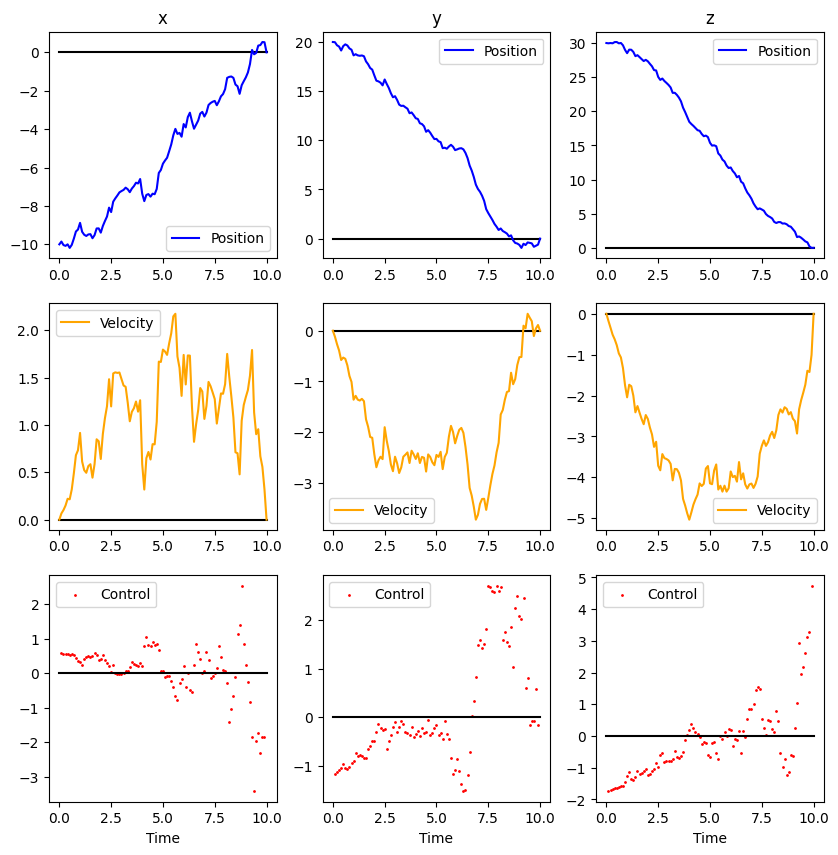

In [113]:
# Initialize things
mu0 = np.array([-10., 20., 30., 0., 0., 0.])
n = 6
N = 100
Q = np.zeros((n, n))
M = np.eye(n)*50
R = np.eye(3)
W = 0.05*np.eye(6)
D = 0.5*np.eye(3)
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
])

xs = np.empty((N+1, n))
us = np.empty((N, 3))
xs[0] = mu0
x = mu0

# Fit the LQR and Kalman Filter
lqr = LQR(Q, M, R, A, B, N)
lqr.fit()
kf = KalmanFilter(A, B, H, W, D, N)
kf.fit()

dt = 1/10
def f(x, u):
    """Return dx/dt using equation (24.7)."""
    return np.concatenate([x[3:], u])

# Set up the simulator
sim = Simulator(f, dt, W=W, D=D, H=H)
sim.set_initial_state(mu0)


for i in range(1, N):
    # Compute the control u0
    u = lqr.compute_control(i, x)
    us[i] = u

    # Evolve the system
    sim.evolve(u)

    # 3. Get the observation
    z = sim.observe()

    x = kf.predict_state(x, u)
    x = kf.update_state(i, x, z)
    xs[i] = x
    
# Plot x
ts = delta_t * np.arange(N+1)
plt.figure(figsize=(10, 10))
plt.subplot(331)
plt.title("x")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,0], label="Position", color="blue")
plt.legend()

# Plot y
plt.subplot(332)
plt.title("y")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,1], label="Position", color="blue")
plt.legend()

# Plot z
plt.subplot(333)
plt.title("z")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,2], label="Position", color="blue")
plt.legend()

# Plot x'
plt.subplot(334)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,3], label="Velocity", color="orange")
plt.legend()

# Plot y'
plt.subplot(335)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,4], label="Velocity", color="orange")
plt.legend()

# Plot z'
plt.subplot(336)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,5], label="Velocity", color="orange")
plt.legend()

# Plot x''
plt.subplot(337)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,0], label="Control", color="red", s=1)
plt.legend()

# Plot y''
plt.subplot(338)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,1], label="Control", color="red", s=1)
plt.legend()

# Plot z''
plt.subplot(339)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,2], label="Control", color="red", s=1)
plt.legend()
plt.show()

# Problem 6

In [154]:
# Set up initial quantities
mass_earth = 5.9722e21
mass_moon = 7.3e19
position_earth = np.array([-96100, -480500, 0], dtype=float)
position_moon = np.array([-96100, -96100, 0], dtype=float)
mu0 = np.array([-48050, -576600, 100, 0, 0, 0], dtype=float)
G = 8.6499e-10

T = 48
N = 1000
dt = T / N
n = 6
M = 10*np.eye(n)
Q = np.zeros((n, n))
R = np.eye(3)
W = (0.05*dt)**2 * np.eye(n)
D = (0.05*dt)**2 * np.eye(3)
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
])

def acceleration_earth(s):
    aE_left = (position_earth - s) / jnp.linalg.norm(position_earth - s, ord=2)
    aE = aE_left * ((G*mass_earth) / jnp.linalg.norm(position_earth - s, ord=2)**2)
    return aE

def acceleration_moon(s):
    aM_left = (position_moon - s) / jnp.linalg.norm(position_moon - s, ord=2)
    aM = aM_left * ((G*mass_moon) / jnp.linalg.norm(position_moon - s, ord=2)**2)
    return aM

def f(x, u):
    # Find accelerations
    aE, aM = acceleration_earth(x[:3]), acceleration_moon(x[:3])
    return jnp.concatenate([x[3:], aE+aM+u])

# Define initial guess
us_guess = np.full((N, 3), np.array([-100, 100, -1]), dtype=float)

# Set up controller, simulator and estimator
controller = Controller(f, Q, M, R, T, N)
controller.fit(mu0, us_guess)
simulator = Simulator(f, dt, W=W, D=D, H=H)
sim.set_initial_state(mu0)
estimator = Estimator(f, dt, H, W, D, N)
estimator.fit(controller.As)

# Initialize things to store data
xs = np.empty((N+1, n))
us = np.empty((N, 3))
xs[0] = mu0
x = mu0

for i in range(1, N):
    # Compute the control u0
    u = controller.compute_control(i, x)
    us[i] = u

    # Evolve the system
    sim.evolve(u)

    # 3. Get the observation
    z = sim.observe()

    x = estimator.predict_state(x, u)
    x = estimator.update_state(i, x, z)
    xs[i] = x
    
xs = controller.xs
us = controller.us
# Incorrect with xs = np.array(sim.true_states)

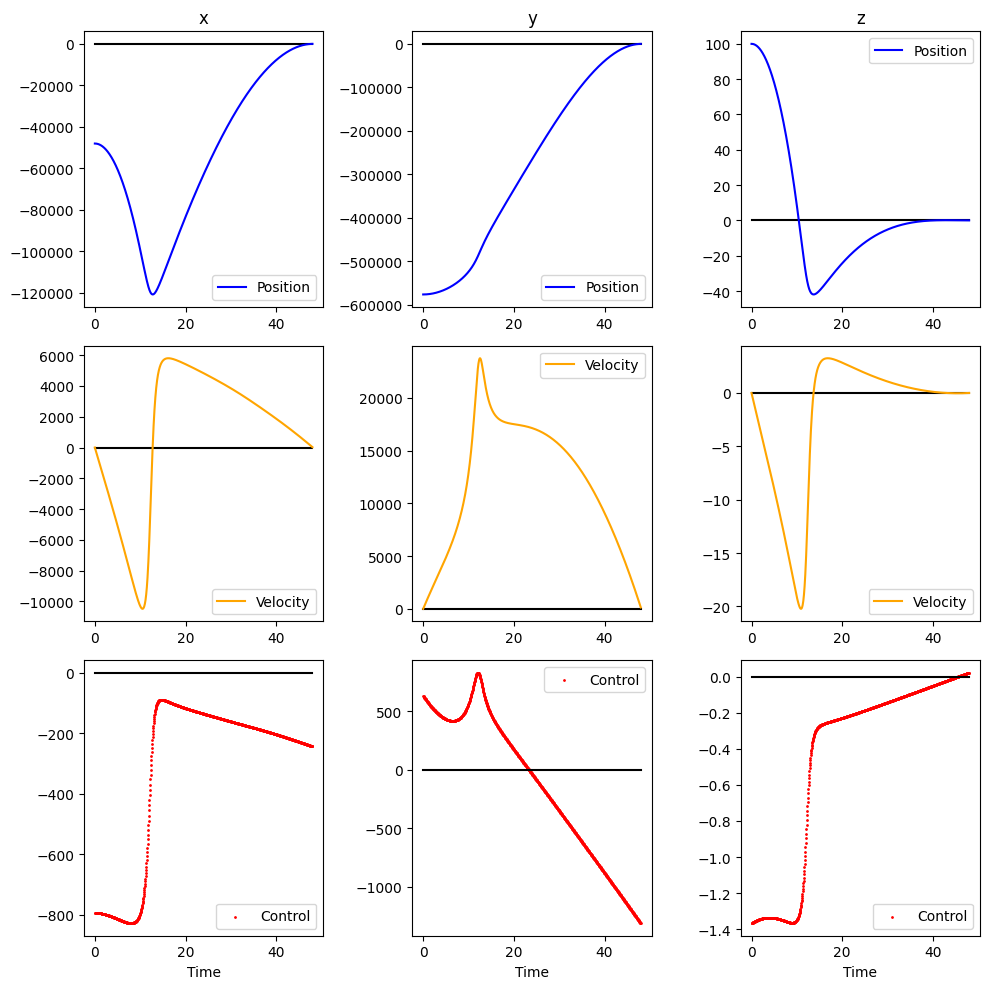

In [151]:
# Plot x
ts = dt * np.arange(N+1)
plt.figure(figsize=(10, 10))
plt.subplot(331)
plt.title("x")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,0], label="Position", color="blue")
plt.legend()

# Plot y
plt.subplot(332)
plt.title("y")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,1], label="Position", color="blue")
plt.legend()

# Plot z
plt.subplot(333)
plt.title("z")
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,2], label="Position", color="blue")
plt.legend()

# Plot x'
plt.subplot(334)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,3], label="Velocity", color="orange")
plt.legend()

# Plot y'
plt.subplot(335)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,4], label="Velocity", color="orange")
plt.legend()

# Plot z'
plt.subplot(336)
plt.plot(ts, ts*0, color="black")
plt.plot(ts, xs[:,5], label="Velocity", color="orange")
plt.legend()

# Plot x''
plt.subplot(337)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,0], label="Control", color="red", s=1)
plt.legend()

# Plot y''
plt.subplot(338)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,1], label="Control", color="red", s=1)
plt.legend()

# Plot z''
plt.subplot(339)
plt.xlabel("Time")
plt.plot(ts, ts*0, color="black")
plt.scatter(ts[1:-1], us[1:,2], label="Control", color="red", s=1)
plt.legend()
plt.tight_layout()
plt.show()

In [155]:
# Animate it
animate2d("results.mp4", xs, us, position_earth, position_moon,
        np.zeros(3), acceleration_earth, acceleration_moon) 

<video src="results.mp4" controls>

In [131]:
# Animate it in 3D
animate3d("results3D.mp4", xs, us, position_earth, position_moon,
    np.zeros(3)) 

<video src="results3D.mp4" controls>